In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report ,f1_score, ConfusionMatrixDisplay
from scipy.special import gamma
warnings.filterwarnings('ignore')

os.makedirs('../results',exist_ok=True)


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


# 1.Load and Explore data

In [3]:
data = pd.read_csv('../data/heart.csv')

print('Data info:\n',data.info())

print('\nData description:\n',data.describe())

print('\nTarget value counts:\n',data['target'].value_counts())

print('\nMissing values:\n',data.isna().sum())

print('\nData shape:\t',data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
Data info:
 None

Data description:
                age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610  

# 2.Feature selection using correlation matrix

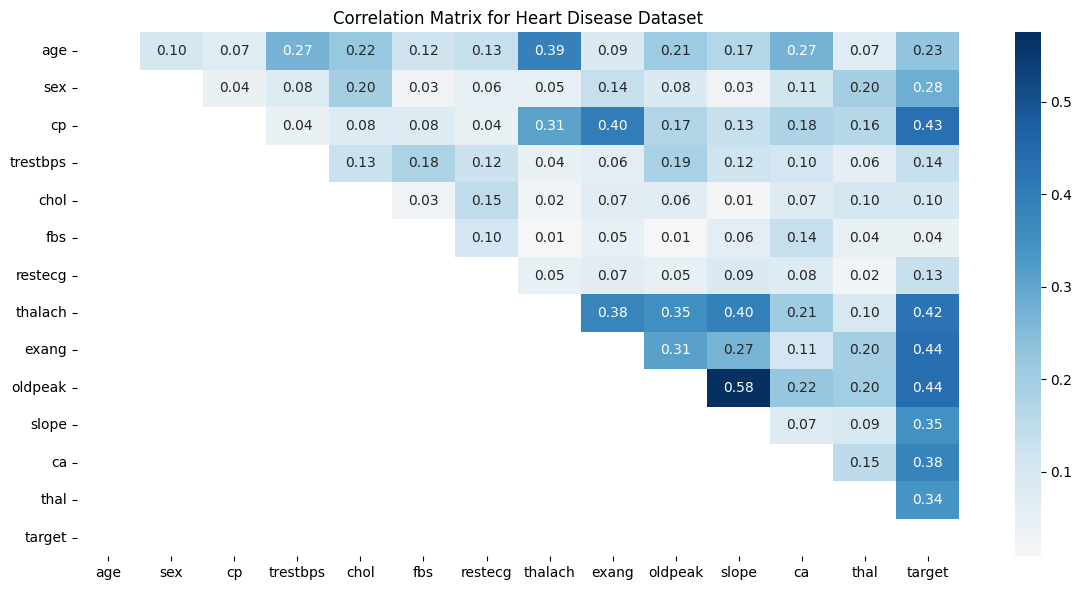

In [4]:
plt.figure(figsize=(12,6))
corr_mat = data.corr().abs()
mask = np.tril(np.ones_like(corr_mat,dtype=bool))
sns.heatmap(corr_mat, mask=mask, annot=True, cmap='RdBu', center=0, fmt='.2f')
plt.title('Correlation Matrix for Heart Disease Dataset')
plt.tight_layout()
plt.savefig('../results/correlation_matrix.png')
plt.show()

Drop highly correlated features if exist

In [5]:
upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.7)]
print(f'Features to drop due to high correlation: {to_drop}')

Features to drop due to high correlation: []


# 3. spliting the data


In [6]:
X = data.drop('target',axis=1)
y = data['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# 4. train and evaluate baseline KNN model

In [7]:
def train_evaluate_knn(X_train,X_test,y_train,y_test ,scaling=False, **kwargs):
    if scaling:
        scaler = StandardScaler()
        X_train_scaled= scaler.fit_transform(X_train)
        X_test_scaled= scaler.transform(X_test)
        print("\nRunning KNN with scaling.")
        X_train_use ,X_test_use = X_train_scaled, X_test_scaled
    else:
        print("\nRunning KNN without scaling.")
        X_train_use ,X_test_use = X_train, X_test

    knn_model = KNeighborsClassifier(**kwargs)
    knn_model.fit(X_train_use,y_train)
    y_pred = knn_model.predict(X_test_use)

    acc = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)

    cv_acc = cross_val_score(knn_model,X_train_use, y_train, cv=5, scoring='accuracy').mean()
    cv_f1 = cross_val_score(knn_model,X_train_use, y_train, cv=5, scoring='f1').mean()


    clr = classification_report(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print(f"\nAccuracy (Test): {acc:.4f} | CV: {cv_acc:.4f}")
    print(f"F1-Score (Test): {f1:.4f} | CV: {cv_f1:.4f}")

    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", clr)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix -KNN {'Scaled' if scaling else 'Unscaled'}')
    plt.savefig(f'../results/cm_KNN_{'Scaled' if scaling else 'Unscaled'}.png')
    return{
        'model':knn_model,
        'scaler':scaler if scaling else None,
        'X_train_use':X_train_use,
        'X_test_use':X_test_use,
        'Accuracy':acc,
        'F1':f1,
        'CV_Acc':cv_acc,
        'CV_F1':cv_f1,
        'Confusion_matrix':cm,
        'Classification_report':clr,
    }

****** Results of the Baseline KNN Model ******

Running KNN without scaling.

Accuracy (Test): 0.6976 | CV: 0.7220
F1-Score (Test): 0.6990 | CV: 0.7267

Confusion Matrix:
 [[71 29]
 [33 72]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.71      0.70       100
           1       0.71      0.69      0.70       105

    accuracy                           0.70       205
   macro avg       0.70      0.70      0.70       205
weighted avg       0.70      0.70      0.70       205


Running KNN with scaling.

Accuracy (Test): 0.8634 | CV: 0.8500
F1-Score (Test): 0.8654 | CV: 0.8565

Confusion Matrix:
 [[87 13]
 [15 90]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86       100
           1       0.87      0.86      0.87       105

    accuracy                           0.86       205
   macro avg       0.86      0.86      0.86       205
weighted avg      

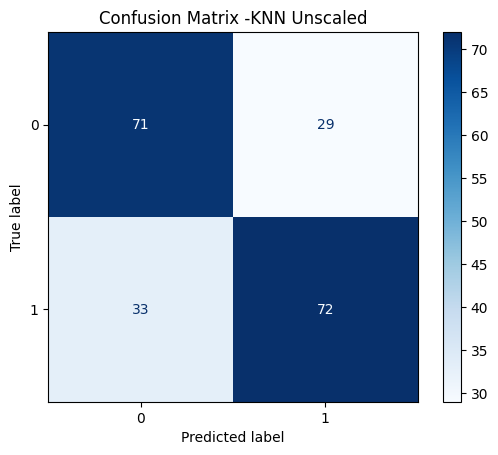

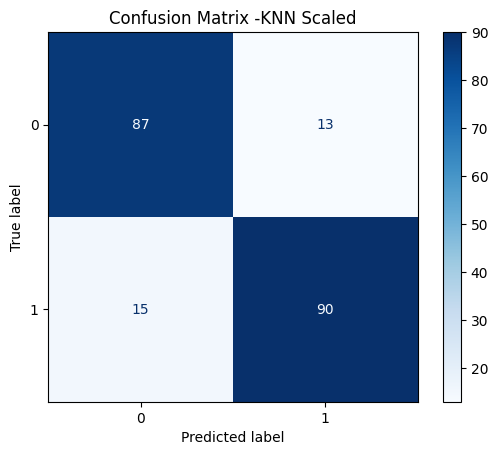

In [8]:
print("****** Results of the Baseline KNN Model ******")
result_unscaled = train_evaluate_knn(X_train,X_test,y_train,y_test,scaling=False)
result_scaled = train_evaluate_knn(X_train,X_test,y_train,y_test,scaling=True)

# 5. OOA Implementation (adapted from Octopus Optimization Algorithm article)
### Levy Flight helper (Eq. 13-14 from article)

In [9]:
def levy_flight(dim, beta=1.5):
    numerator = gamma(1 + beta) * np.sin(np.pi * beta /2)
    denomenator = gamma((1 + beta) /2) * beta * (2 ** ((beta-1) /2))
    sigma = (numerator / denomenator) ** (1/beta)
    u = np.random.normal(0, 1, dim)
    v = np.random.normal(0,1, dim)
    step = 0.01 * u * sigma/ (np.abs(v) ** (1/beta))

    return step

In [10]:
def ooa_optimize(obj_func, lb, ub, dim=2, N=30, max_iter=80, Nh=20, Ns=10 ):
    np.random.seed(42)
    pop = np.random.uniform(lb,ub,(N,dim))
    fitness = np.array([obj_func(ind) for ind in pop])
    best_idx = np.argmin(fitness)
    best_pos = pop[best_idx].copy()
    best_fit = fitness[best_idx]
    history = [-best_fit]

    vr , ll = 3, 0.8

    for t in range(1,max_iter +1):
        for i in range(Nh):
            trans = (2 * np.random.rand() -1) * vr * (1-t / max_iter)
            if abs(trans) < ll:
                new_pos = pop[i] + np.random.rand() * (best_pos - pop[i]) * levy_flight(dim)
                new_pos = np.clip(new_pos,lb,ub)
                new_fit = obj_func(new_pos)
                if new_fit < fitness[i]:
                    pop[i] = new_pos
                    fitness[i] = new_fit
                    if new_fit < best_fit:
                        best_pos, best_fit = new_pos,new_fit
        
        for i in range(Nh, N):
            new_pos = pop[i] + (2 * np.random.rand(dim) - 1) * (ub - lb)  * ( 1-t / max_iter)
            new_pos = np.clip(new_pos, lb, ub)
            new_fit = obj_func(new_pos)
            if new_fit < fitness[i]:
                pop[i] = new_pos
                fitness[i] = new_fit
                if new_fit < best_fit:
                    best_pos, best_fit = new_pos, new_fit
        
        history.append(-best_fit)
        
        if t%20 ==0:
            print(f"Iter {t}: Best CV Acc ={-best_fit:.4f}")

    plt.figure(figsize=(8,5))
    plt.plot(history)
    plt.xlabel('Iterations')
    plt.ylabel('OOA Convergence for KNN Tuning (Heart Disease)')
    plt.grid(True)
    plt.savefig('../results/ooa_convergence.png')
    plt.show()

    return best_pos , -best_fit

In [11]:
scaler_ooa = StandardScaler()
X_train_scaled = scaler_ooa.fit_transform(X_train)
X_test_scaled = scaler_ooa.transform(X_test)

In [12]:
# objective

def knn_objective(params):
    k = int(np.clip(params[0],2,30))  
    p = np.clip(params[1],1,3)
    knn =KNeighborsClassifier(n_neighbors=k, p=p, metric='minkowski')
    
    #cv on train for robust opt
    cv_acc = cross_val_score(knn,X_train_scaled,y_train,cv=5, scoring='accuracy').mean()

    return -(cv_acc) # min -cv acc



**** OOA Optimazation (CV based) ****
Iter 20: Best CV Acc =0.9390
Iter 40: Best CV Acc =0.9390
Iter 60: Best CV Acc =0.9390
Iter 80: Best CV Acc =0.9390


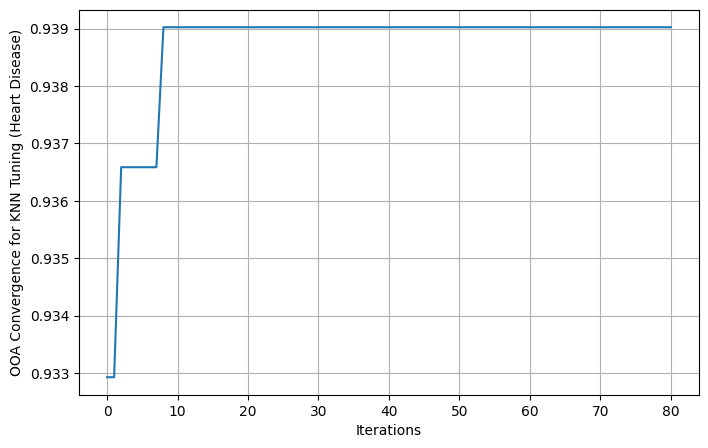


Best OOA Params : k=1, p=2.29
Best OOA CV Accuracy:0.9390


In [13]:
lb = np.array([1,1])
ub = np.array([30,3])
dim = 2 

print("\n**** OOA Optimazation (CV based) ****")
best_params, best_cv_acc = ooa_optimize(knn_objective,lb,ub,dim,N=30,max_iter=80)
best_k, best_p = int(best_params[0]),best_params[1]

print(f"\nBest OOA Params : k={best_k}, p={best_p:.2f}")
print(f"Best OOA CV Accuracy:{best_cv_acc:.4f}")

In [14]:
# eval tuned on test 

knn_opt = KNeighborsClassifier(n_neighbors=best_k, p=best_p, metric='minkowski')
knn_opt.fit(X_train_scaled,y_train)
y_pred_opt = knn_opt.predict(X_test_scaled)

acc_opt = accuracy_score(y_test,y_pred_opt)
f1_opt = f1_score(y_test,y_pred_opt)
cv_acc_opt = cross_val_score(knn_opt,X_train_scaled,y_train,cv=5,scoring='accuracy').mean()
cv_f1_opt = cross_val_score(knn_opt,X_train_scaled,y_train,cv=5,scoring='f1').mean()

cm_opt = confusion_matrix(y_test, y_pred_opt)
clr_opt = classification_report(y_test, y_pred_opt)

In [15]:
#overfit checker
train_acc = accuracy_score(y_train,knn_opt.predict(X_train_scaled))
print(f"Overfit checker : Train acc={train_acc:.4f}  vs Test= {acc_opt:.4f} (Diff < 0.05 -->ok)")

Overfit checker : Train acc=1.0000  vs Test= 1.0000 (Diff < 0.05 -->ok)


In [16]:
print(f"\nOOA-KNN Test Acc:{acc_opt:.4f} | CV-acc: {cv_acc_opt:.4f}")
print(f"OOA-KNN Test F1:{acc_opt:.4f} | CV-f1: {cv_f1_opt:.4f}")


OOA-KNN Test Acc:1.0000 | CV-acc: 0.9805
OOA-KNN Test F1:1.0000 | CV-f1: 0.9810


In [17]:
print("\nOOA Confusion Matrix:\n", cm_opt)
print("\nOOA Classification Report:\n", clr_opt)


OOA Confusion Matrix:
 [[100   0]
 [  0 105]]

OOA Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



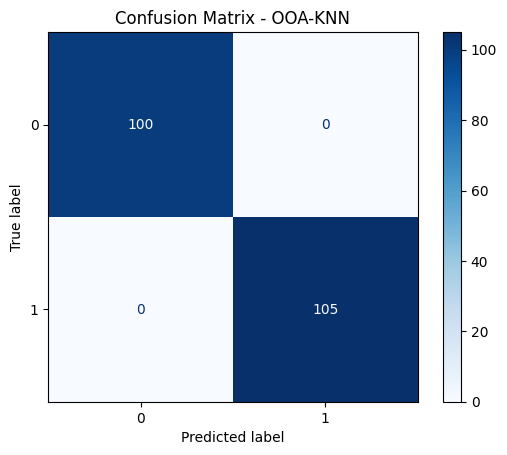

In [18]:
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt)
disp_opt.plot(cmap='Blues')
plt.title('Confusion Matrix - OOA-KNN')
plt.savefig('../results/cm_ooa_knn.png')
plt.show()

In [19]:
#comparision table 
print("\n***** Performance Comparision ****")
comparison_data={
    'Model':['KNN Unscaled (Default)','KNN Scaled (Default)','OOA-KNN (Tuned)'],
    'Test Acc' : [result_unscaled['Accuracy'],result_scaled['Accuracy'],acc_opt],
    'Test F1' : [result_unscaled['F1'],result_scaled['F1'],f1_opt],
    'CV Acc' : [result_unscaled['CV_Acc'],result_scaled['CV_Acc'],cv_acc_opt],
    'CV F1' : [result_unscaled['CV_F1'],result_scaled['CV_F1'],cv_f1_opt],
}
comparision = pd.DataFrame(comparison_data)
print(comparision.round(4))


***** Performance Comparision ****
                    Model  Test Acc  Test F1  CV Acc   CV F1
0  KNN Unscaled (Default)    0.6976   0.6990  0.7220  0.7267
1    KNN Scaled (Default)    0.8634   0.8654  0.8500  0.8565
2         OOA-KNN (Tuned)    1.0000   1.0000  0.9805  0.9810


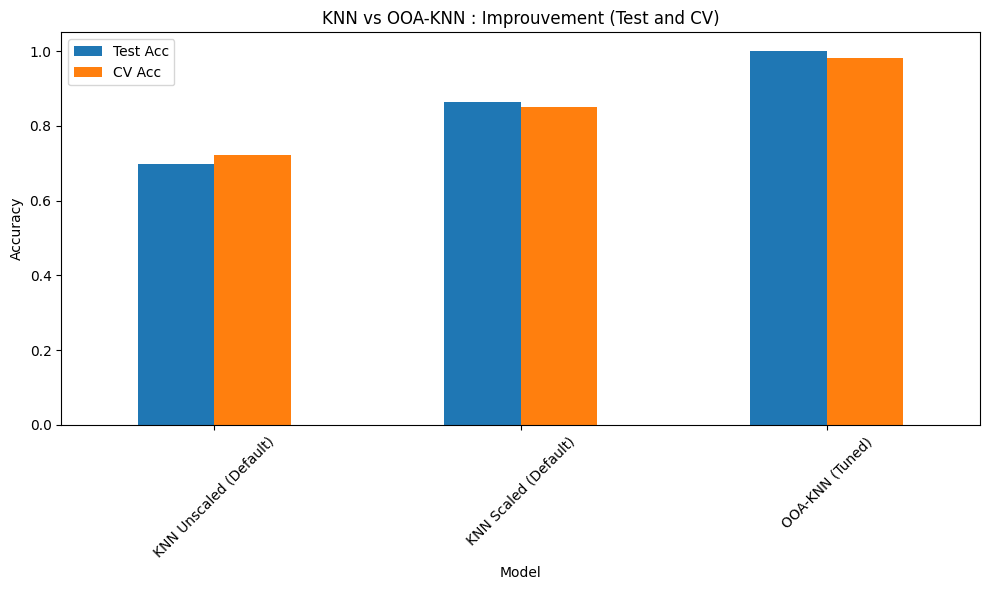

In [20]:
#viz the comparition
comparision.set_index('Model')[['Test Acc','CV Acc']].plot(kind='bar',figsize=(10,6))
plt.title('KNN vs OOA-KNN : Improuvement (Test and CV)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('../results/performance_comparision.png')
plt.show()
